In [1]:
# micrograd is an autograd engine, which implements backpropagation
# Backpropagation : Its an algo that efficntely eveluate the gradient of somekind of loss function with respect to weights of a neural network
# so we can iteratively tune the weights of the network to minimize the loss function and therefore improve that acurracy of nueral network

In [2]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(-5,5, 0.25)


In [3]:
def f(x):
    return 3 * x**2 -4*x + 5

In [4]:
f(3)

20

In [5]:
print(f"XS : {xs}")
ys = f(xs)
print("")
print(f"YS : {ys}")

XS : [-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]

YS : [100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


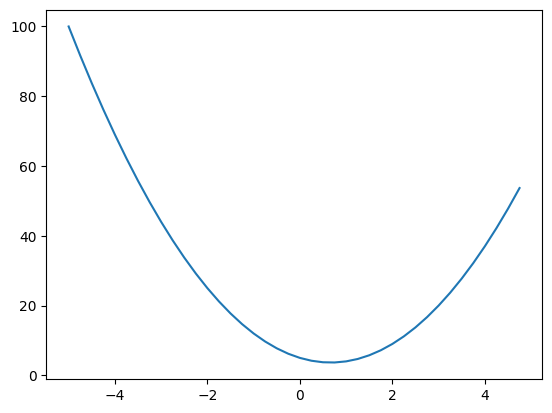

In [6]:
plt.plot(xs, ys)


In [7]:
# Derivative
a = 2.0
b= -3.0
c = 10.0
d = a*b + c
d

4.0

In [8]:
# derivatibve of c wrt a
# bump a by a tiny amount of h
d1 = a*b + c
h = 0.0001
d2 = (a+h)*b + c

d1, d2

(4.0, 3.999699999999999)

In [9]:
print("slope", (d2-d1)/h)

slope -3.000000000010772


### FROM 20 MINUTES ONWARDS...

In [10]:
class Value:
    def __init__(self, data, _children = (), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), "+", )
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)

        out = Value(self.data * other.data,(self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Value(np.tanh(self.data), (self,), "tanh")
        def _backward():
            self.grad += (1.0 - np.tanh(self.data)**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
            
    
    def __rmul__(self,data):
        return self * data
    
    def __radd__(self, other): # other + self
        return self + other
        

In [11]:
a = Value(20, label="a")
b = Value(10, label="b")

a, b


c = a*b; c.label = "c"
c._prev



{Value(data=10), Value(data=20)}

In [12]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

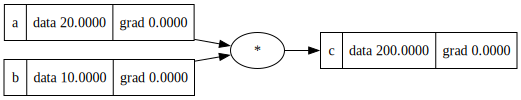

In [13]:
draw_dot(c)

In [14]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
b = Value(8.7, label="b")

# multiply weights by inputs
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"

# dot product / or summarization
n = x1w1 + x2w2 + b; n.label = "n"

# activation function
o = n.tanh(); o.label = "o"

o



Value(data=0.9910074536781176)

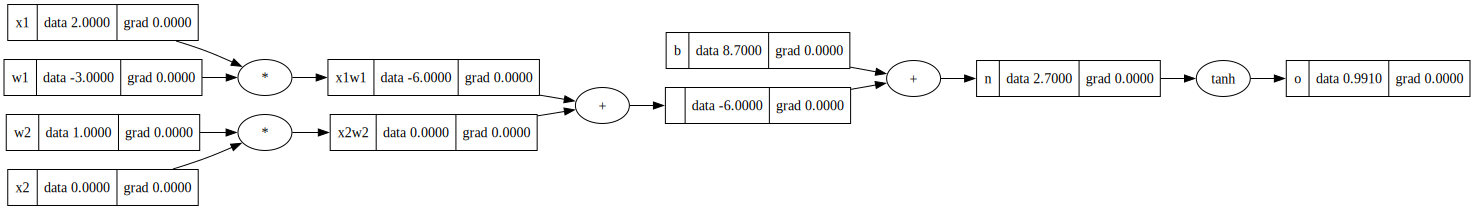

In [15]:
draw_dot(o)

In [16]:
o.backward()

In [17]:
import torch

# inputs
x1 = torch.tensor([2.0]); x1.requires_grad =True
x2 = torch.tensor([0.0]); x2.requires_grad =True
# weights
w1 = torch.tensor([-3.0]); w1.requires_grad =True
w2 = torch.tensor([1.0]); w2.requires_grad =True

b =  torch.tensor([8.7]); w2.requires_grad =True



x1_w1 = x1 * w1
x2_w2 = x2 * w2

n = x1_w1 + x2_w2 + b

n

o = torch.tanh(n)

o

o.backward()

In [18]:
x1.grad

tensor([-0.0537])

In [38]:
import random
class Neuron:
    def __init__(self, nin):
        self.weights = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # do : w*x + b
        raw_act = sum((wi * xi for wi, xi in zip(self.weights,x)), b)
        o = raw_act.tanh()
        return o
    
    
class Layer:
    def __init__(self,nin, nout):
        self.neuron = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neuron]
        return outs[0] if len(outs) == 1 else outs
        
class MLP:
    def __init__(self, nin ,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
        

In [39]:
x = [2.0, 3.0, -1.0]

one = MLP(2, [4,4,1])

one(x)

/var/folders/c7/z9xcy1l1481bm3hgrydzvlxm0000gn/T/ipykernel_71287/674984296.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  out = Value(np.tanh(self.data), (self,), "tanh")


Value(data=tensor([1.0000]))

/var/folders/c7/z9xcy1l1481bm3hgrydzvlxm0000gn/T/ipykernel_71287/674984296.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  out = Value(np.tanh(self.data), (self,), "tanh")


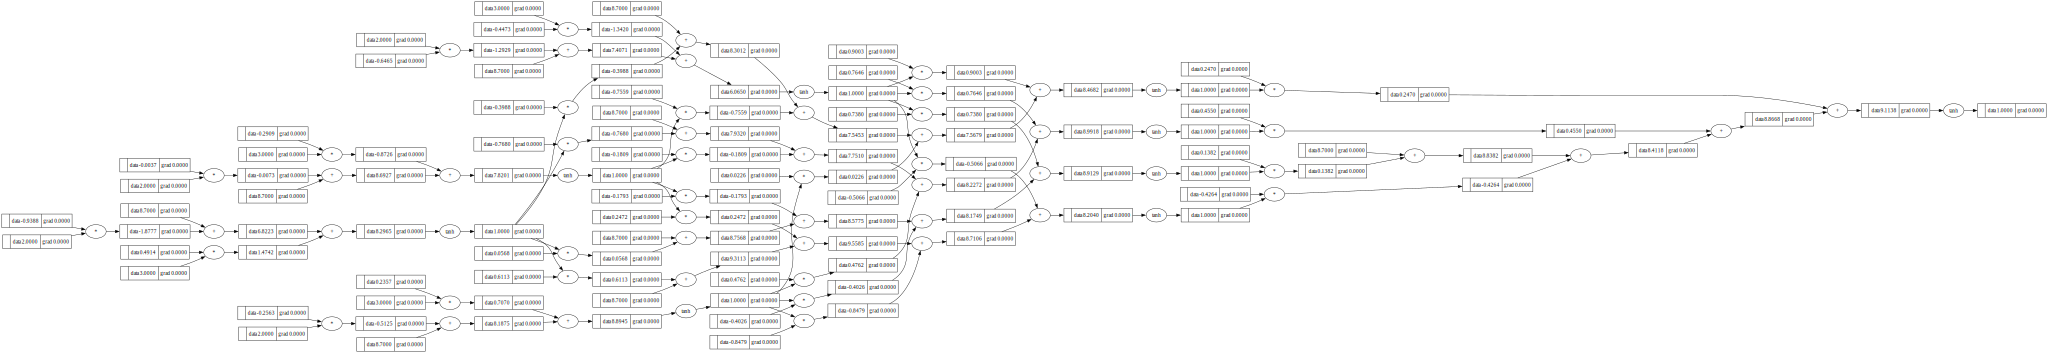

In [40]:
draw_dot(one(x))